In [0]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

train_on_gpu = torch.cuda.is_available()

In [0]:
#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[files for files in os.listdir(self.file_path)]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def sp(self, name):
        if(name[0] != 't'):
            return name.split('_')
        else:
            return name[15:23].split('_') 
        
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=self.sp(file_name)
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    
    def get_classes(self):
        classes_mapping = {  'C0': 0,
                             'C1': 1,
                             'C2': 2,
                             'C3': 3,
                             'C4': 4,
                             'C5': 5,
                             'C6': 6,
                             'C7': 7,
                             'C8': 8,
                             'C9': 9,
                             'V0': 10,
                             'V1': 11,
                             'V2': 12,
                             'V3': 13,
                             'V4': 14,
                             'V5': 15,
                             'V6': 16,
                             'V7': 17,
                             'V8': 18,
                             'V9': 19}
        return classes_mapping
       

In [0]:
print(train_on_gpu)
device = torch.device("cuda:0")
torch.cuda.set_device(device)
print(device)

True
cuda:0


In [0]:
transform = transforms.Compose([transforms.ToTensor()])

In [0]:
class Params(object):
    def __init__(self, batch_size, epochs, seed, log_interval):
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.log_interval = log_interval

args = Params(512, 36, 0, 5)

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1WuQU0Vm7TIOR_BVImTflTaLI7qFBc97Q'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train.zip')

In [0]:
file_id = '1Q799Tmi6OQBJwNhpR7jCPt2-2oN4KDtH'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test.zip')

In [0]:
import zipfile
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('./train')
with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('./test')

In [0]:
full_data_unnorm = VowelConsonantDataset("./train/train",train=True, transform=transform)

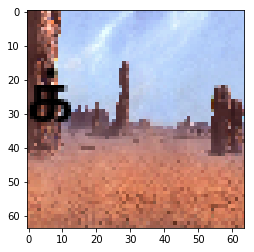

In [0]:
import matplotlib.image as mpimg
img=mpimg.imread('./train/train/V0_C1_13.png')
imgplot = plt.imshow(img)
plt.show()

In [0]:
norm_loader = torch.utils.data.DataLoader(full_data_unnorm, batch_size=10000, shuffle=False)

In [0]:
pop_mean0 = [0.48657233, 0.44117808, 0.40056407]
pop_std0 = [0.27085045, 0.23359329, 0.22115886]
pop_mean1 = [0.485, 0.456, 0.406]
pop_std1 = [0.229, 0.224, 0.225]

In [0]:
transformNorm = transforms.Compose([transforms.ToTensor()])

In [0]:
transformNormAug = transforms.Compose([ #transforms.RandomResizedCrop(64),
                                        #transforms.Grayscale(3),
                                        #transforms.RandomVerticalFlip(p=0.5), 
                                        #transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor()
                                        ])

In [0]:
full_data = VowelConsonantDataset("./train/train",train=True,transform=transformNormAug)

In [0]:
full_data_acc = VowelConsonantDataset("./train/train",train=True,transform=transformNormAug)

In [0]:
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size
train_data, validation_data = random_split(full_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=100, shuffle=True)

In [0]:
print("Train Size: " + str(train_size) + "\nTest Size: " + str(test_size))

Train Size: 9000
Test Size: 1000


In [0]:
# Temporarily halting test output.. don't run this.

test_data = VowelConsonantDataset("./test/test/",train=False,transform=transformNorm)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

In [0]:
class ModelC(nn.Module):
    def __init__(self, nH = 32): 
        super(ModelC, self).__init__()
        self.classifier_cnn = nn.Sequential(
            nn.Conv2d(3, 64, 5),            # (N, 3, 64, 64) -> (N, 16, 62, 62)
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 5, padding=2),# (N, 16, 60, 60) -> (N, 32, 60, 60)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 64, 5),           # (N, 32, 30, 30) -> (N, 32, 26, 26)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3),    
            nn.BatchNorm2d(64),             # (N, 32, 26, 26) -> (N, 32, 24, 24)
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),            # (N, 32, 24, 24) -> (N, 64, 22, 22)
            nn.LeakyReLU(),
            nn.MaxPool2d(2, stride=2),      # (N, 64, 22, 22) -> (N, 64, 11, 11)
            nn.Conv2d(128, 128, 3),         # (N, 64, 11, 11) -> (N, 64, 9, 9)
            nn.BatchNorm2d(128),               
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, 3),         # (N, 64, 9, 9) -> (N, 64, 7, 7)
            nn.LeakyReLU()
        ).to(device)
        self.classifier_fc_C = nn.Sequential(
            nn.Linear(128*7*7, 512, bias=True),
            nn.BatchNorm1d(512),
            nn.Tanh(),
            nn.Linear(512, 256, bias=True),
            nn.BatchNorm1d(256),
            nn.Tanh(),
            nn.Linear(256,128, bias=True),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(128,64, bias=True),
            nn.BatchNorm1d(64),
            nn.Tanh(),
            nn.Linear(64, 10, bias=True)
        ).to(device)
        self.classifier_fc_V = nn.Sequential(
            nn.Linear(128*7*7, 512, bias=True),
            nn.BatchNorm1d(512),
            nn.Tanh(),
            nn.Linear(512, 256, bias=True),
            nn.BatchNorm1d(256),
            nn.Tanh(),
            nn.Linear(256,128, bias=True),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(128,64, bias=True),
            nn.BatchNorm1d(64),
            nn.Tanh(),
            nn.Linear(64, 10, bias=True)
        ).to(device)
        self.weight_init_conv(self.classifier_cnn)
        self.weight_init_fc(self.classifier_fc_V)
        self.weight_init_fc(self.classifier_fc_C)
    def weight_init_fc(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
    def weight_init_conv(self, m):
        if type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
    def forward(self, x):
        x = self.classifier_cnn(x)
        x = x.view(x.size(0), -1)
        y1 = self.classifier_fc_C(x)
        y2 = self.classifier_fc_V(x)
        return y1, y2

In [0]:
def train(epoch):
    acc = 0
    acct = 0
    lossT, lossV = 0, 0
    exp_lr_scheduler.step()
    modelC.train()
    lossV = 0
    for batch_id, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optC.zero_grad()
        op = modelC(inputs)
        outputsC, outputsV = op[:, :10], op[:, 10:]
        loss = loss_fn(outputsC, labels[:, 0, :].argmax(dim=1)) + loss_fn(outputsV, labels[:, 1, :].argmax(dim=1))
        loss.backward()
        optC.step()
        
        if batch_id % args.log_interval == 0:
            pos = epoch * len(train_loader) + batch_id
            
            print('Train Epoch: {} ({:.0f}%)\tLoss: {:.3f}'.format(
                epoch, 100. * batch_id / len(train_loader), loss.data.item()))
    
    modelC.eval()
    
    for i, data in enumerate(train_loader_acc):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        op = modelC(inputs)
        outputsC, outputsV = op[:, :10], op[:, 10:]
        lossT += (loss_fn(outputsC, labels[:, 0, :].argmax(dim=1)) + loss_fn(outputsV, labels[:, 1, :].argmax(dim=1))).data.item()
    
        acct += ((outputsC.argmax(dim=1) == labels[:,0,:].argmax(dim=1)).cpu().numpy() * (outputsV.argmax(dim=1) == labels[:,1,:].argmax(dim=1)).cpu().numpy()).sum()
    
    acct /= 10000
    print("\nTrain Loss on full data at epoch end: %.2f"%(lossT/(i+1)))
    print("Train Accuracy on full data: %.2f"%(acct))

    for i, data in enumerate(validation_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        op = modelC(inputs)
        outputsC, outputsV = op[:, :10], op[:, 10:]
        lossV += (loss_fn(outputsC, labels[:, 0, :].argmax(dim=1)) + loss_fn(outputsV, labels[:, 1, :].argmax(dim=1))).data.item()    
        acc += ((outputsC.argmax(dim=1) == labels[:,0,:].argmax(dim=1)).cpu().numpy() * (outputsV.argmax(dim=1) == labels[:,1,:].argmax(dim=1)).cpu().numpy()).sum()
    
    acc /= test_size
    print("Validation Accuracy: %.2f"%(acc))
    print("Validation Loss: %.2f\n"%(lossV/(test_size/100)))
   


In [0]:
def train1(epoch):
    acc = 0
    acct = 0
    lossT, lossV = 0, 0
    #exp_lr_scheduler.step()
    modelC.train()
    lossV = 0
    for batch_id, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optC.zero_grad()
        outputs = modelC(inputs)
        outputC, outputV = outputs[:, 10], outputs[:, 10:]
        loss = loss_fn(outputC, labels[:, 0, :].argmax(dim=1)) + loss_fn(outputsV, labels[:, 1, :].argmax(dim=1))
        loss.backward()
        optC.step()
        
        if batch_id % args.log_interval == 0:
            pos = epoch * len(train_loader) + batch_id
            
            print('Train Epoch: {} ({:.0f}%)\tLoss: {:.3f}'.format(
                epoch, 100. * batch_id / len(train_loader), loss.data.item()))


In [0]:
def val_acc():
    lossV, acc = 0, 0
    modelC.eval()
    for i, data in enumerate(validation_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        op = modelC(inputs)
        outputsC, outputsV = op[:, :10], op[:, 10:]
        lossV += loss_fn(outputsC, labels[:, 0, :].argmax(dim=1)).data.item() + loss_fn(outputsV, labels[:, 1, :].argmax(dim=1)).data.item()    
        acc += ((outputsC.argmax(dim=1) == labels[:,0,:].argmax(dim=1)).cpu().numpy().sum() * (outputsV.argmax(dim=1) == labels[:,1,:].argmax(dim=1)).cpu().numpy()).sum()

    acc /= 1000
    print("Val Accuracy: %.2f"%(acc))
    print("Val Loss: %.2f\n"%(lossV/(i+1)))
    
def train_acc():
    lossV, acc = 0, 0
    modelC.eval()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        op = modelC(inputs)
        outputsC, outputsV = op[:, :10], op[:, 10:]
        lossV += loss_fn(outputsC, labels[:, 0, :].argmax(dim=1)).data.item() + loss_fn(outputsV, labels[:, 1, :].argmax(dim=1)).data.item()    
        acc += ((outputsC.argmax(dim=1) == labels[:,0,:].argmax(dim=1)).cpu().numpy() * (outputsV.argmax(dim=1) == labels[:,1,:].argmax(dim=1)).cpu().numpy()).sum()

    acc /= 10000
    print("Train Accuracy: %.2f"%(acc))
    print("Train Loss: %.2f\n"%(lossV/(i+1)))

In [0]:
torch.cuda.empty_cache()

In [0]:
train_loader_acc = torch.utils.data.DataLoader(full_data, batch_size=100, shuffle=False)

In [0]:
modelC = models.vgg19_bn()

#num_ftrs = modelC.fc.in_features

modelC.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=2048, bias=True),
    nn.BatchNorm1d(2048),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1024, out_features=10, bias=True)
  )

modelC = modelC.to(device)

loss_fn = nn.CrossEntropyLoss()

optC = optim.Adam(modelC.parameters(), lr=0.001)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optC, step_size=7, gamma=0.5)

for epoch in range(1,25):
    train(epoch)

In [0]:
acct = 0
lossT= 0
modelC.eval()
for i, data in enumerate(train_loader_acc):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputC = modelC(inputs)
    lossT += (loss_fn(outputC, labels[:, 0, :].argmax(dim=1))).data.item()# + loss_fn(outputsV, labels[:, 1, :].argmax(dim=1))).data.item()
    acct += (outputC.argmax(dim=1) == labels[:,0,:].argmax(dim=1)).cpu().numpy().sum()# * (outputsV.argmax(dim=1) == labels[:,1,:].argmax(dim=1)).cpu().numpy()).sum()

acct /= 10000
print("\nTrain Loss on full data: %.2f"%(lossT/(i+1)))
print("Train Accuracy on full data: %.2f"%(acct))

2 submission cells based on which output to use..

In [0]:
submission = {}
submission['ImageId'] = []
submission['Class'] = []
s=""
modelC.eval()

for i, data in enumerate(test_loader):
    inputs, labels = data
    inputs = inputs.to(device)
    op = modelC(inputs)
    s = "V" + str(op[:, :10].argmax(dim=1).data.item()) + "_C" + str(op[:, 10:].argmax(dim=1).data.item())
    submission['ImageId'].append(labels[0])
    submission['Class'].append(s)

In [0]:
submission = {}

for i, data in enumerate(test_loader):
    inputs, labels = data
    inputs = inputs.to(device)
    op = model(inputs)
    s = "V" + str(op[:, :10]) + "_C" + op[:, 10:]
    submission['ImageId'].append(labels)
    submission['Class'].append(s)

In [0]:
submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submission.csv", index=False)